<a href="https://colab.research.google.com/github/anuramubc/AudioBased_CNNClassifier/blob/main/Baseline_model1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anuradharamachandran","key":"586a825a572497ed5328c4482d22c686"}'}

In [ ]:
# list files in directoy to ensure kaggle dataset was imported
# ! ls 
# ! ls -lha kaggle.json

In [ ]:
! pip install kaggle
! mkdir ~/.kaggle # mbr uses this to load dataset; comment out if not needed
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# load birdclef dataset from kaggle
! kaggle competitions download -c birdclef-2023

100% 4.90G/4.91G [00:54<00:00, 106MB/s] 
100% 4.91G/4.91G [00:54<00:00, 96.9MB/s]


In [ ]:
! mkdir birdclef_data

In [ ]:
! unzip birdclef-2023.zip -d birdclef_data

Streaming output truncated to the last 5000 lines.
  inflating: birdclef_data/train_audio/rerswa1/XC330427.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC330925.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC331732.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC333007.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC333008.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC333855.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC334159.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC334160.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC334161.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC370598.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC371021.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC371367.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC376096.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC379520.ogg  
  inflating: birdclef_data/train_audio/rerswa1/XC381917.ogg  
  inflating: birdcl

In [ ]:
import os
import pandas as pd
PATH_DATASET = "/content/birdclef_data/"
path_csv = os.path.join(PATH_DATASET, "train_metadata.csv")
train_orig = pd.read_csv(path_csv)
# print(len(train_orig)) # size of original data set


In [ ]:
pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Number of unique species in original data set: 264


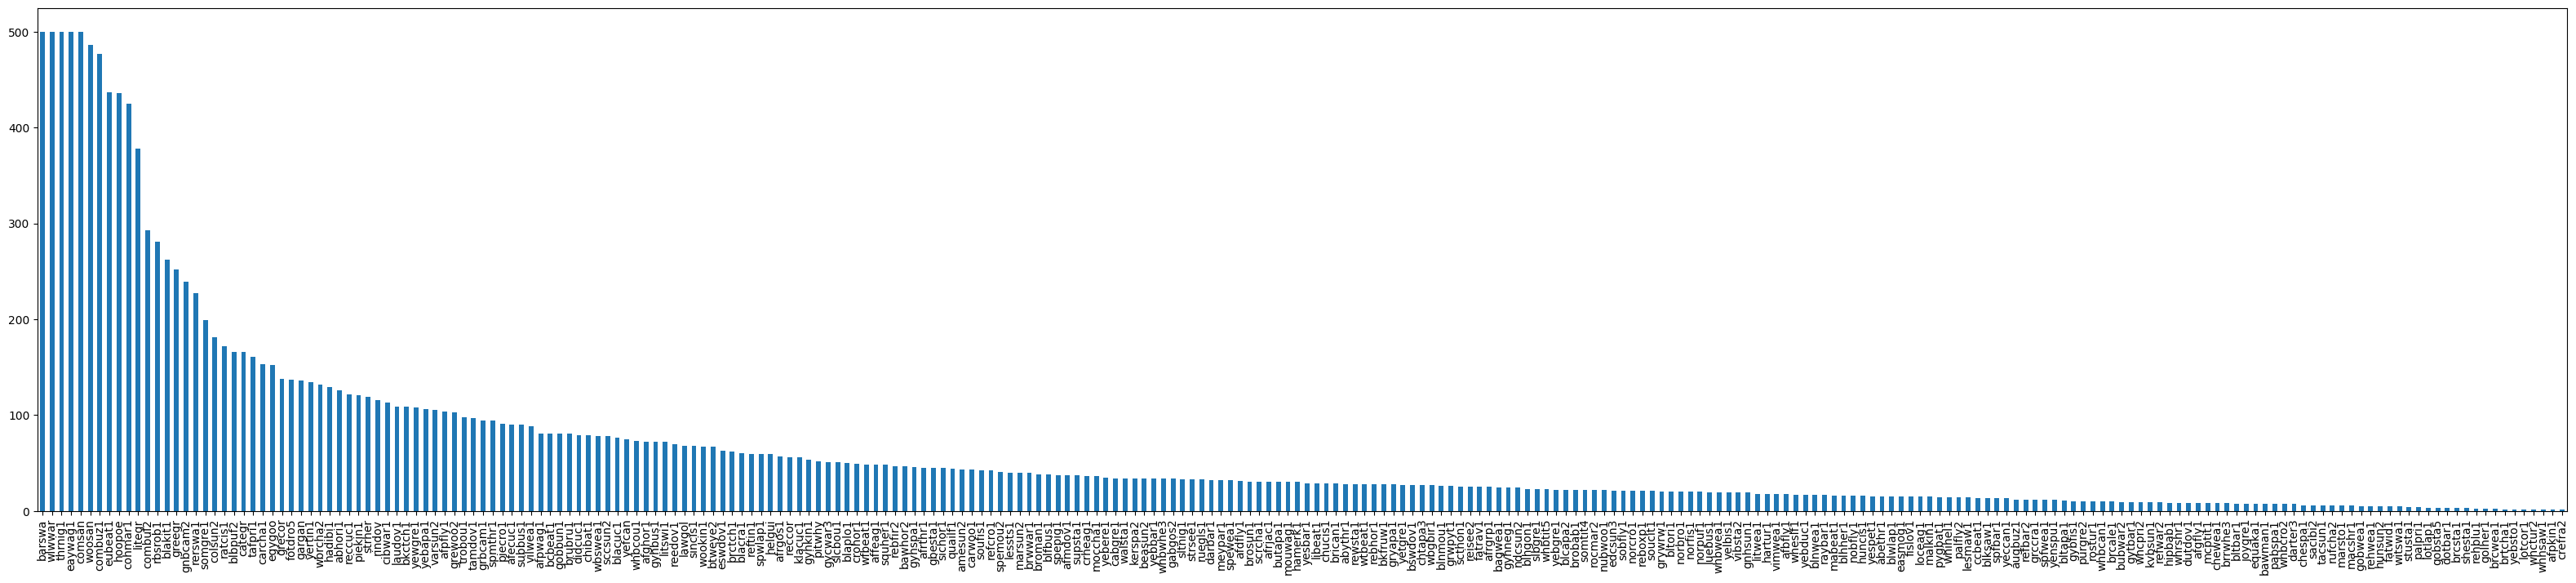

In [ ]:
#number of samples per species
species = train_orig['primary_label'].value_counts()
#Visualize the distribution of samples per species
species.plot(kind ='bar', figsize = (40, 8))
#From the plot it looks like certain species 500 audio samples, while some species only have <10 samples
#Challenge in this dataset: Imbalance of training examples for different species
print('Number of unique species in original data set:', len(species))

<Axes: >

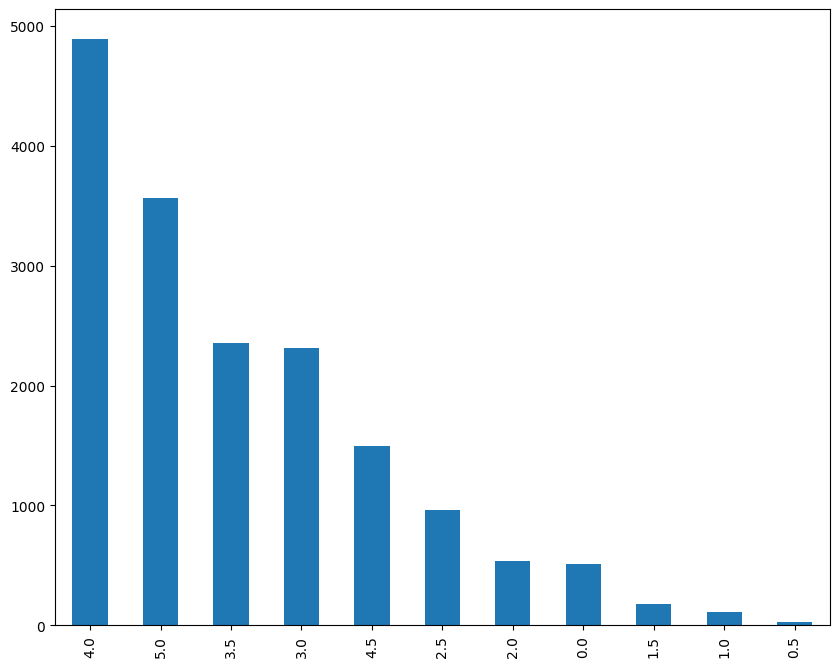

In [ ]:
# quality of audio sample
# most of the audio samples have an audio quality of more than 4.0
rating = train_orig['rating'].value_counts()
rating.plot(kind = 'bar', figsize = (10, 8))

# REQUIRED PACKAGES

In [ ]:
# import packages for audio and pre train processing
import librosa
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import sklearn
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 

# FUNCTIONS FOR OVER SAMPLING (SMOTE AND ADASYN)


In [ ]:
#Oversampling using SMOTE
def overSampleSMOTE(X,y):
  #Create an object of SMOTE() class
  sm = SMOTE()
  #use sm.fit_sample(X,y) to oversample X and y 
  X,y = sm.fit_resample(X,y)
  return X,y


In [ ]:
#Oversampling using ADASYN
def overSampleADASYN(X,y):
  #Create an object of ADASYN() class
  ada = ADASYN()
  #use ada.fit_sample(X,y) to oversample X and y 
  X,y = ada.fit_sample(X,y)
  return X,y

# FILTERING THE DATASET TO TRAIN AND TEST

In [ ]:
RANDOM_SEED = 1337
MAX_AUDIO_FILES = 5000#200

In [ ]:
#Keep only bird species with highest quality audio files (quality >= 4)
#Audio data quality based on "rating" column in train_metadata.csv

print('NUMBER OF SAMPLES IN ORIGINAL TRAIN DATA SET:', len(train_orig))

train_meta = train_orig[train_orig.rating  >=4.0]

#Out of 16941 rows, only 9952 rows have an audio quality of >=4
#there are 264 unique species in the dataset
print('NUMBER OF SAMPLES W/ AUDIO QUALITY >= 4:', len(train_meta))

birds_count = {}

#bird species: provides the name of the bird species and count holds the number of samples for each species
for bird_species, count in zip(train_meta.primary_label.unique(), train_meta.groupby("primary_label")["primary_label"].count().values):
    birds_count[bird_species] = count

#Select only those bird species that have more than 200 audio samples   
#They are ['strher', 'rewsta1', 'hadibi1', 'litswi1', 'wookin1', 'rebfir2', 'tamdov1', 'grewoo2', 'tacsun1', 'whcpri2', 'vimwea1'] 
most_represented_birds = [key for key, value in birds_count.items() if value >= 88]

#Get rows and the corresponding labels that correspond to only the most_represented_birds
train  = train_meta.query("primary_label in @most_represented_birds")
labels = sorted(train.primary_label.unique())

# Let's see how many species and samples we have left
print('NUMBER OF SPECIES IN TRAIN DATA:', len(labels)) # n=11
print('NUMBER OF SAMPLES IN TRAIN DATA:', len(train)) # n=3169
print('LABELS:', most_represented_birds)

#test data 500 audio files with quality <4
test_data = train_orig[train_orig.rating < 4.0]
test_set = shuffle(test_data, random_state = RANDOM_SEED)[:500]
test_labels = sorted(test_set.primary_label.unique())
print('NUMBER OF SAMPLES IN TEST DATA:', len(test_set))
print('NUMBER OF SPECIES IN TRAIN DATA:', len(test_labels)) 

NUMBER OF SAMPLES IN ORIGINAL TRAIN DATA SET: 16941
NUMBER OF SAMPLES W/ AUDIO QUALITY >= 4: 9952
NUMBER OF SPECIES IN TRAIN DATA: 25
NUMBER OF SAMPLES IN TRAIN DATA: 4916
LABELS: ['barswa', 'blakit1', 'categr', 'cohmar1', 'combul2', 'combuz1', 'comsan', 'eaywag1', 'egygoo', 'eubeat1', 'fotdro5', 'gnbcam2', 'grecor', 'greegr', 'hoopoe', 'litegr', 'ratcis1', 'rbsrob1', 'reccuc1', 'rerswa1', 'somgre1', 'thrnig1', 'wbrcha2', 'wlwwar', 'woosan']
NUMBER OF SAMPLES IN TEST DATA: 500
NUMBER OF SPECIES IN TRAIN DATA: 164


In [ ]:
test_speciesname = sorted(test_set.primary_label.unique())
print(test_speciesname)

['abhori1', 'afdfly1', 'afghor1', 'afmdov1', 'afpfly1', 'afpwag1', 'afrgos1', 'afrjac1', 'afrthr1', 'bagwea1', 'barswa', 'bawhor2', 'bcbeat1', 'beasun2', 'bkctch1', 'blacra1', 'blacuc1', 'blakit1', 'blaplo1', 'blbpuf2', 'blcapa2', 'blfbus1', 'blhgon1', 'blhher1', 'blnmou1', 'bltbar1', 'brcale1', 'brctch1', 'brican1', 'brosun1', 'brubru1', 'brwwar1', 'bswdov1', 'btweye2', 'butapa1', 'carcha1', 'carwoo1', 'categr', 'chespa1', 'chibat1', 'chtapa3', 'cibwar1', 'cohmar1', 'colsun2', 'combul2', 'combuz1', 'comsan', 'crohor1', 'didcuc1', 'easmog1', 'eaywag1', 'egygoo', 'eswdov1', 'eubeat1', 'fislov1', 'fotdro5', 'gabgos2', 'gargan', 'gbesta1', 'gnbcam2', 'gnhsun1', 'gobbun1', 'golher1', 'grbcam1', 'grccra1', 'grecor', 'greegr', 'grewoo2', 'grwpyt1', 'gybfis1', 'gycwar3', 'gyhbus1', 'gyhkin1', 'gyhneg1', 'gyhspa1', 'hadibi1', 'hamerk1', 'hoopoe', 'huncis1', 'kerspa2', 'klacuc1', 'kvbsun1', 'laudov1', 'lawgol', 'lesmaw1', 'lessts1', 'libeat1', 'litegr', 'litswi1', 'luebus1', 'macshr1', 'marsto1

# EDA OF TRAINING SET

4916


Text(0.5, 1.0, '')

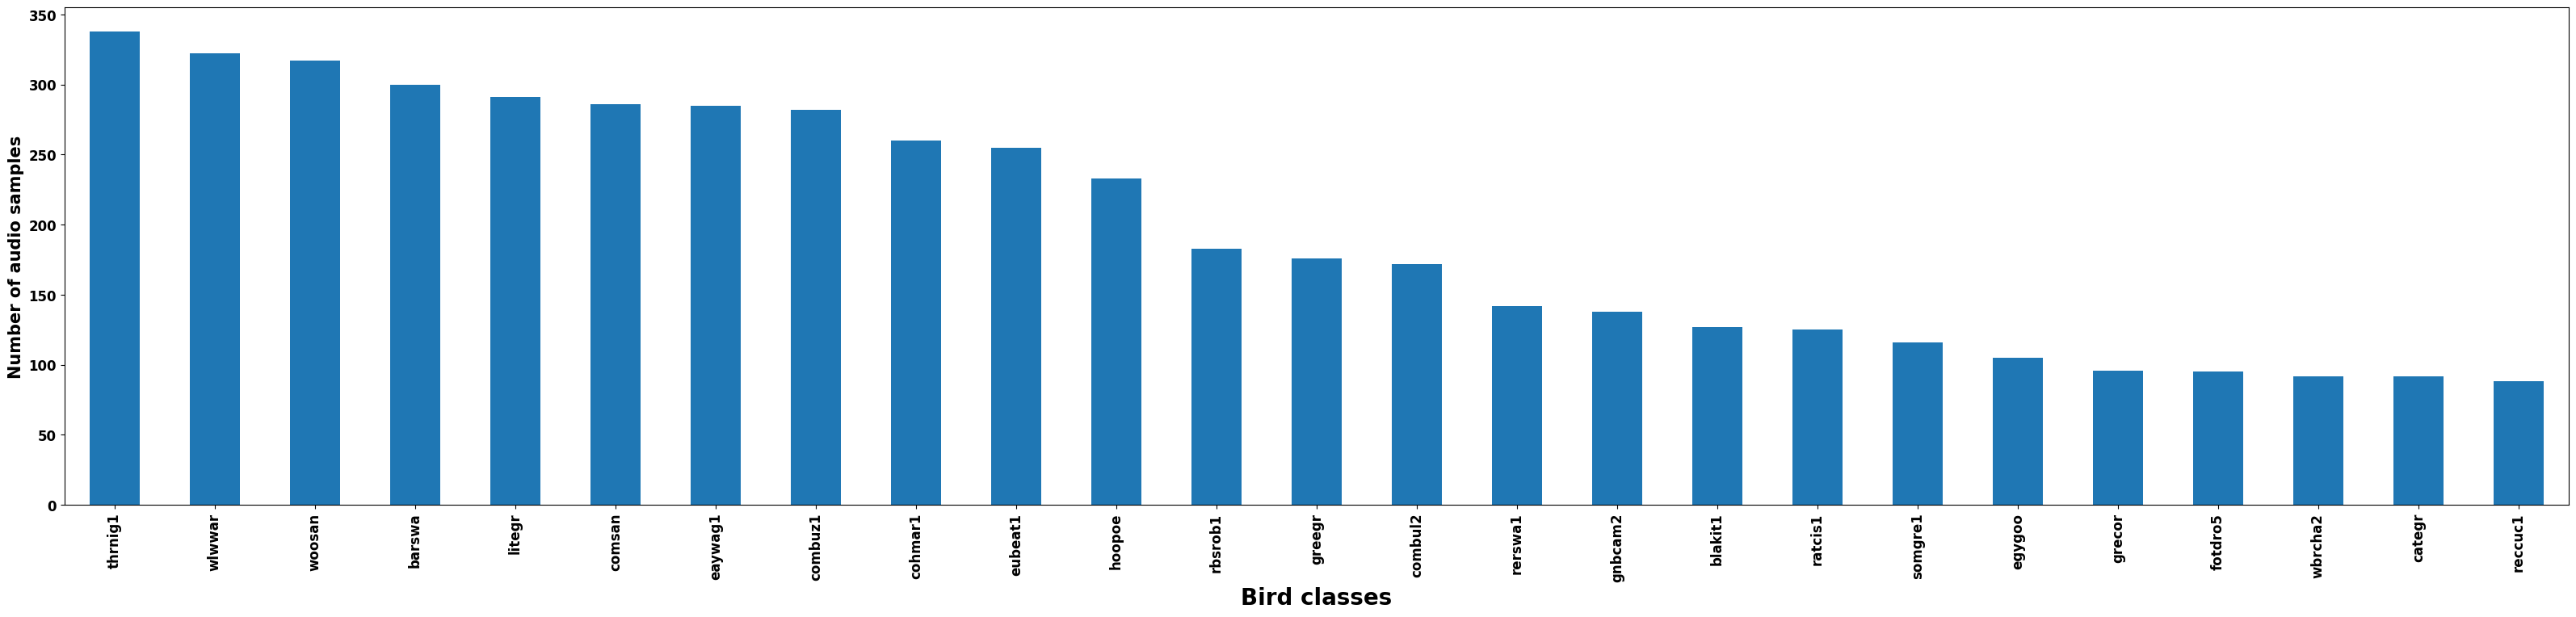

In [ ]:
# Shuffle the training data and limit the number of audio files to MAX_AUDIO_FILES
train = shuffle(train, random_state=RANDOM_SEED)[:MAX_AUDIO_FILES]
print(len(train))
#number of samples per species
species = train['primary_label'].value_counts()
#Visualize the distribution of samples per species
species.plot(kind ='bar', figsize = (40,8))
plt.xlabel('Bird classes', fontweight='bold', fontsize = 20)
plt.ylabel('Number of audio samples', fontweight='bold', fontsize = 15)
plt.xticks(fontweight='bold', fontsize =12)
plt.yticks(fontweight='bold', fontsize =12)
plt.title('')

In [ ]:
# range of number of samples per species 
print(min(species), max(species))

88 338


<Axes: >

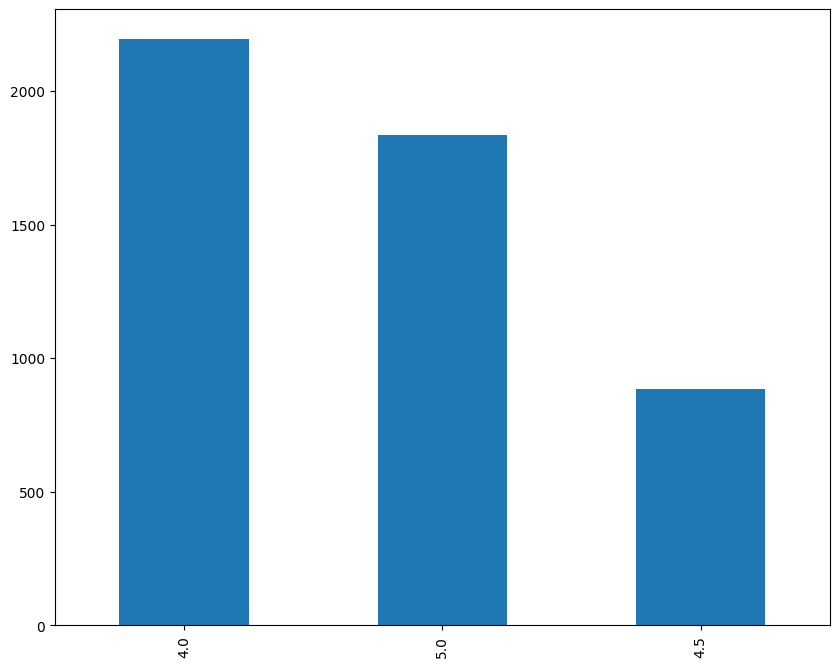

In [ ]:
#Quality of audio sample
#most of the audio samples have an audio quality of more than 4.0
rating = train['rating'].value_counts()
rating.plot(kind = 'bar', figsize = (10,8))

# FUNCTIONS TO GENERATE SPECTROGRAM AND RESHAPING IT

In [ ]:
# Spectrogram Parameters - will experiment with different values

SAMPLE_RATE = 32000 # sampling rate of input data
SPEC_SHAPE = (48, 128) # BASELINE MODEL: (48, 128)
N_FFT = 2048 # also trying 512 and 2048 (default) # BASELINE MODEL: 1024
N_MELS = SPEC_SHAPE[0] # number of mel bands; spectrogram height
CLIP_LEN = 5 # length of music clip; 5 seconds

# frequency range: f_min, f_max
# based on other models, 500-12500 Hz is an appropriate range for birds
F_MIN = 500 
F_MAX = 12500

HOP_LEN = int(CLIP_LEN * SAMPLE_RATE/(SPEC_SHAPE[1] - 1))
#hop_length = 512 # by default, win_length = n_fft 
#WIN_LEN = duration * samplerate/ hop_length


In [ ]:
#get_melspectrogram() - Function that returns a spectrogram from the audio file
def get_melspectrogram(filename, primarylabel, outputdir):
  """
  get_melspectrogram(): Input arguements:
  filename - consists of the path of the audio files 
  primarylabel - represents the name of the species
  outputdir - directory to save the mel spectrogram images

  This function returns a spectrogram from a audio file
  """
  #Using librosa package to load the audio file. It loads the audio file as a floating point time series.
  audio_data, rate = librosa.load(filename, sr = SAMPLE_RATE)
  #Trimming leading and trailing silence from an audio signal
  audio_data, x = librosa.effects.trim(audio_data)

  #only take 5s samples and add them to the dataframe
  song_sample = []
  sample_length = 5 * SAMPLE_RATE
  
  count = 0
  saved_samples = []
  
  #First split the audio_data into chunks of length = sample_length = 5*sample_rate
  for idx in range(0, len(audio_data), sample_length):
    #song_sample contains the chunk of length idx+sample_length
    song_sample = audio_data[idx:idx + sample_length]

    if len(song_sample) >= sample_length:
      #convert audio_data to mel spectrogram
      mel = librosa.feature.melspectrogram(y=song_sample, 
                                           sr = SAMPLE_RATE, 
                                           n_fft = N_FFT,
                                           hop_length = HOP_LEN,
                                           n_mels = N_MELS,
                                           fmin=F_MIN, 
                                           fmax=F_MAX)
                                           #pad_mode='reflect') # experimenting with this
      
      #convert melspectrogram to decibel scale
      mel = librosa.power_to_db(mel)

      #normalize the scale
      normalized_mel = sklearn.preprocessing.minmax_scale(mel)

      #save image in directory outputdir+primarylabel
      save_dir = os.path.join(outputdir, primarylabel)
      if not os.path.exists(save_dir):
        os.makedirs(save_dir)

      #file path to save the spectrogram
      save_path = os.path.join(save_dir, filename.rsplit(os.sep, 1)[-1].rsplit('.',1)[0] + '_' + str(count) +'.png')

      #convert array into an image
      im = Image.fromarray((normalized_mel*255.0).astype('uint8'), mode='L')
      im.save(save_path)

      saved_samples.append(save_path)
      count += 1

  return saved_samples


In [ ]:
def reshapeSpectograms(SPECS, labels):
  specs, label = [], []
  with tqdm(total=len(SPECS)) as pbar:

    for path in SPECS:
        pbar.update(1)
        
        # Get file path of image from TRAIN_SPECS and open image path to save in spec
        spec = Image.open(path)

        # Convert image from PNG to np array
        spec = np.array(spec, dtype = 'float16')

        # Normalize array between 0 and 1
        spec -= spec.min()
        spec /= spec.max()
        if not spec.max() == 1.0 or not spec.min() == 0.0:
          continue

        # Add channel axis to 2D array
        spec = np.expand_dims(spec, -1)

        # Add new dimension for batch size
        spec = np.expand_dims(spec, 0)
        
        # Add to train data
        if len(specs) == 0:
            specs = spec
        else:
            specs = np.vstack((specs, spec))

        # Add to label data
        target = np.zeros((len(labels)), dtype='float16')
        bird = path.split(os.sep)[-2]
        
        #if bird not in bird_count.get('bird_name'):
          #bird_count.get('bird_name').append(bird)
        # bird_count.get('samples').append(1)
        #print(labels.index(bird))
        target[labels.index(bird)] = 1.0
        if len(label) == 0:
            label = target
        else:
            label = np.vstack((label, target))
  return specs, label
      

# EXTRACTING SPECTROGRAMS FOR TRAINING AND VALIDATION SETS


In [ ]:
#Extracting the train set spectrograms
inputdir = "/content/birdclef_data/train_audio"
outputdir = "/content/birdclef_data/train_spectrogram"
mel = []
with tqdm(total=len(train)) as pbar:
  for idx, row in train.iterrows():
    pbar.update(1)
    if row.primary_label in most_represented_birds:
      audiopath = os.path.join(inputdir, row.filename)
      mel += get_melspectrogram(audiopath, row.primary_label, outputdir)
TRAIN_SPECS = shuffle(mel, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS FOR TRAINING AND VALIDATION'.format(len(TRAIN_SPECS)))


100%|██████████| 4916/4916 [22:30<00:00,  3.64it/s]

SUCCESSFULLY EXTRACTED 45575 SPECTROGRAMS FOR TRAINING AND VALIDATION


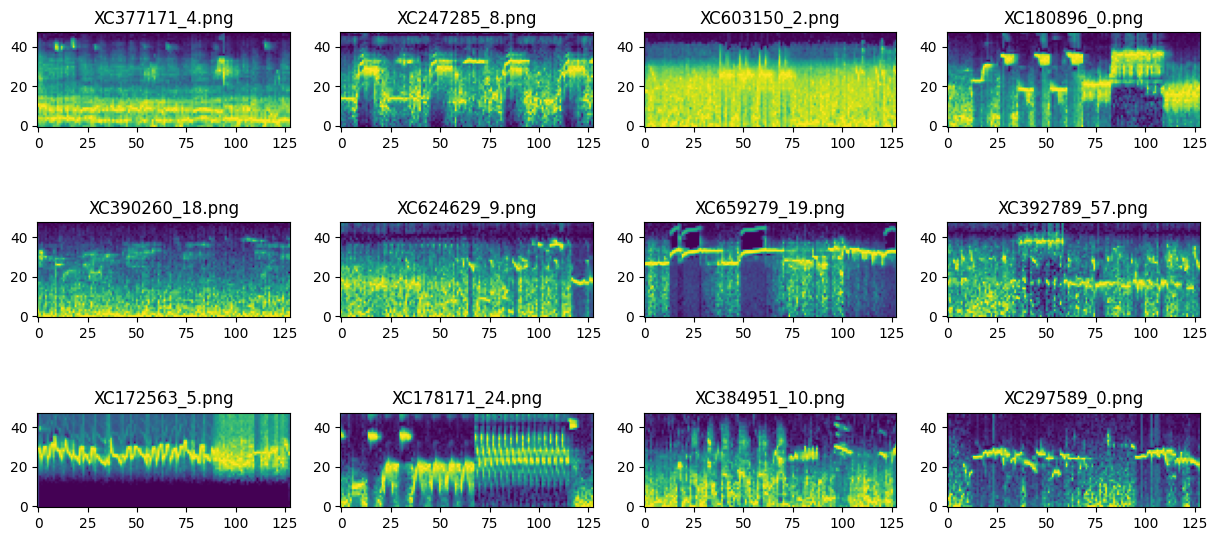

In [ ]:
# Plot the first 12 log spectrograms of TRAIN_SPECS
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TRAIN_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TRAIN_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

In [ ]:
specs, label = [], []

i = 0

with tqdm(total=len(TRAIN_SPECS)) as pbar:

  for path in TRAIN_SPECS:
      pbar.update(1)
      
      # Get file path of image from TRAIN_SPECS and open image path to save in spec
      spec = Image.open(path)

      # Convert image from PNG to np array
      spec = np.array(spec, dtype = 'float16')

      # Normalize array between 0 and 1
      spec -= spec.min()
      spec /= spec.max()
      if not spec.max() == 1.0 or not spec.min() == 0.0:
        continue

      # Add channel axis to 2D array
      spec = np.expand_dims(spec, -1)

      # Add new dimension for batch size
      spec = np.expand_dims(spec, 0)
      
      # Add to train data
      if len(specs) == 0:
          specs = spec
      else:
          specs = np.vstack((specs, spec))

      # Add to label data
      target = np.zeros((len(labels)), dtype='float16')
      bird = path.split(os.sep)[-2]
      
      #if bird not in bird_count.get('bird_name'):
        #bird_count.get('bird_name').append(bird)
       # bird_count.get('samples').append(1)
      #print(labels.index(bird))
      target[labels.index(bird)] = 1.0
      if len(label) == 0:
          label = target
      else:
          label = np.vstack((label, target))

100%|██████████| 45575/45575 [1:19:58<00:00,  9.50it/s]


# TRAIN and VALIDATION SPLIT AND ITS DISTRIBUTION VISUALIZATION


In [ ]:
# Split into TRAIN set and TEST set
train_specs, test_specs, train_labels, test_labels = train_test_split(specs, label, test_size=0.2)
print("Train spectrogram dataset shape", train_specs.shape)
print("Test spectrogram dataset shape", test_specs.shape)
print("Train label dataset shape", train_labels.shape)
print("Test label dataset shape", test_labels.shape)

Train spectrogram dataset shape (36460, 48, 128, 1)
Test spectrogram dataset shape (9115, 48, 128, 1)
Train label dataset shape (36460, 25)
Test label dataset shape (9115, 25)


In [ ]:
#Plot distribution of number of spectrograms vs species
def spec_distribution(samplesize, labels, sampleinfo):
  perspecies_Sample = np.sum(samplesize, axis = 0)
  labels = np.array(labels)
  bird_count = pd.DataFrame({'samples': perspecies_Sample}, columns = ['samples'], index = labels)
  bird_count.plot(kind = 'bar')
  plt.title(f"Distribution of spectrogram per species in {sampleinfo}")
  plt.show()

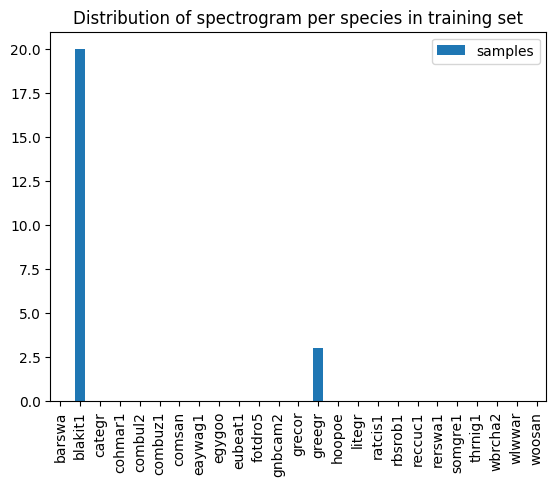

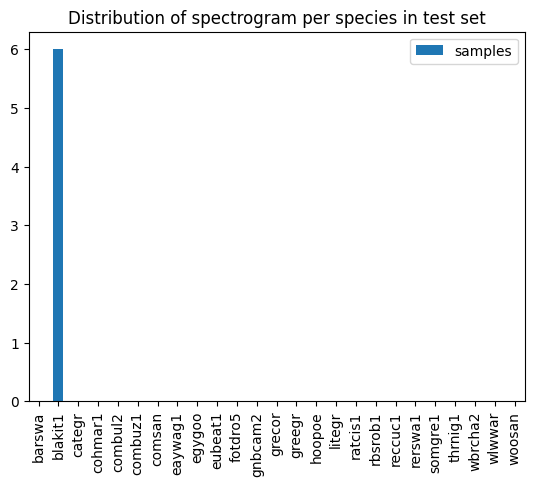

In [ ]:
#Sample distribution in training data
spec_distribution(train_labels, labels, 'training set')
spec_distribution(test_labels, labels, 'test set')

In [ ]:
# sanity check to ensure we are inputting correct dims for model
print(train_specs.shape[1:])

# number of different labels = 11 species
NUM_CLASSES = train_labels.shape[1]
print("Number of species (classes) is", NUM_CLASSES)


(48, 128, 1)
Number of species (classes) is 25


In [ ]:
! pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# TRAINING THE MODEL


## Model 1 Training

In [ ]:
# import deep learning modules
import tensorflow as tf
from tensorflow import keras
from keras.utils import Sequence
from keras.models import Sequential, Model
from keras.layers import (Layer, Dense, Dropout, Flatten, Conv1D, Conv2D, MaxPool1D, MaxPool2D,
BatchNormalization, LayerNormalization, Activation, ReLU)
from keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
#from tensorflow.keras.layers import layer
from tensorflow.keras.regularizers import l1, l2

In [ ]:
# source: https://github.com/jeremypagirsky/birdcall_classification/blob/main/birdclef-audio-classification.ipynb
# source: https://www.kaggle.com/code/stefankahl/birdclef2021-model-training/notebook 

# INPUT DIMS FOR BASELINE MODEL: (48, 128)

# Define Training Model
# arch: 3-layer CNN: Conv -> BN -> ReLU -> MaxPool (-> Softmax)

# include for reproducibility
tf.random.set_seed(RANDOM_SEED) 

model = Sequential()

# Input_shape= H, W, C, where:
# H = spectrogram height;
# w = spectrogram width; and 
# C = number of channels (for BW images, C=1)

# Conv Layer 1; K=16 filters of size 3x3 
# By default, stride=1; padding=0 
#kernel_regularizer = l1(0.01),
model.add(Conv2D(filters = 16, kernel_size=3, activation=None, input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)))
model.add(BatchNormalization())
model.add(keras.layers.ReLU())
model.add(MaxPool2D((2, 2))) #2x2
    
# Conv Layer 2; K=32 filters of size 3x3 
#tf.keras.layers.Conv2D(32, (3, 3), activation=None)
model.add(Conv2D(filters = 32, kernel_size=3, activation=None))
model.add(BatchNormalization())
model.add(keras.layers.ReLU())
model.add(MaxPool2D((2, 2))) #2x2
    
# Conv Layer 3; K=32 filters of size 3x3 
model.add(Conv2D(filters = 32, kernel_size=3, activation=None))
model.add(BatchNormalization())
model.add(keras.layers.ReLU())
model.add(MaxPool2D((2, 2))) #2x2

# Conv Layer 4; K=128 filters of size 3x3 
#model.add(Conv2D(filters = 128, kernel_size=3, activation=None))
#model.add(BatchNormalization())
#model.add(layers.ReLU())
#model.add(MaxPool2D((2, 2)))
    
model.add(Flatten())
    
# Dense block
model.add(Dense(128, activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASSES, activation='relu'))
    
# Classification layer
model.add(Activation('softmax'))

print('MODEL HAS {} PARAMETERS.'.format(model.count_params()))


MODEL HAS 247097 PARAMETERS.


In [ ]:
# print model summary to see how many params we have
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 46, 126, 16)       160       
                                                                 
 batch_normalization_3 (Batc  (None, 46, 126, 16)      64        
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 46, 126, 16)       0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 23, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 21, 61, 32)        4640      
                                                                 
 batch_normalization_4 (Batc  (None, 21, 61, 32)      

In [ ]:
# define F1 score, as we will use this as validation metric
#f1_score = F1Score(num_classes=len(train_labels.shape[1]),average='macro',name='f1_score')

# define callbacks to monitor training
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                patience=2, 
                                                verbose=1, 
                                                factor=0.5),
             keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           verbose=1,
                                           patience=20),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5', 
                                             monitor='val_loss',
                                             verbose=0,
                                             save_best_only=True)]

In [ ]:
# compile model, using params: optimizer=Adam; loss=cross-entropy; metric=accuracy
learn_rate = 1e-3 # learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate = learn_rate),
              loss=keras.losses.CategoricalCrossentropy(label_smoothing = 0.01),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
# train model 
EPOCHS = 50
BATCH_SIZE = 32
initial_results = model.fit(train_specs, 
          train_labels,
          batch_size=BATCH_SIZE, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1140/1140 [==============================] - 22s 8ms/step - loss: 2.6284 - accuracy: 0.2752 - recall: 0.1109 - precision: 0.7404 - val_loss: 2.2418 - val_accuracy: 0.3922 - val_recall: 0.2504 - val_precision: 0.6945 - lr: 0.0010
Epoch 2/50
1140/1140 [==============================] - 8s 7ms/step - loss: 2.2406 - accuracy: 0.3736 - recall: 0.2131 - precision: 0.8073 - val_loss: 2.0116 - val_accuracy: 0.4366 - val_recall: 0.3004 - val_precision: 0.8315 - lr: 0.0010
Epoch 3/50
1140/1140 [==============================] - 8s 7ms/step - loss: 2.0767 - accuracy: 0.4134 - recall: 0.2584 - precision: 0.8237 - val_loss: 1.9126 - val_accuracy: 0.4829 - val_recall: 0.3601 - val_precision: 0.7387 - lr: 0.0010
Epoch 4/50
1140/1140 [==============================] - 8s 7ms/step - loss: 1.9300 - accuracy: 0.4494 - recall: 0.2983 - precision: 0.8422 - val_loss: 1.7618 - val_accuracy: 0.5243 - val_recall: 0.3266 - val_precision: 0.9152 - lr: 0.0010
Epoch 5/50
1140/1140 [=====================

In [ ]:
def visualize_training_results(results):
    """
    Displays training loss and accuracy metrics across epochs.
    """
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'train_loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'train_accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

    plt.figure()
    plt.plot(history['val_recall_6'])
    plt.plot(history['recall_6'])
    plt.legend(['val_recall', 'train_recall'])
    plt.title('Recall')
    plt.xlabel('Epochs')
    plt.ylabel('Recall')
    plt.show()

    plt.figure()
    plt.plot(history['val_precision_6'])
    plt.plot(history['precision_6'])
    plt.legend(['val_precision', 'train_precision'])
    plt.title('Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.show()

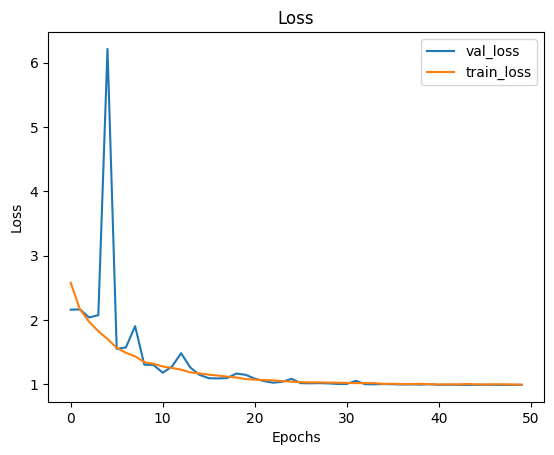

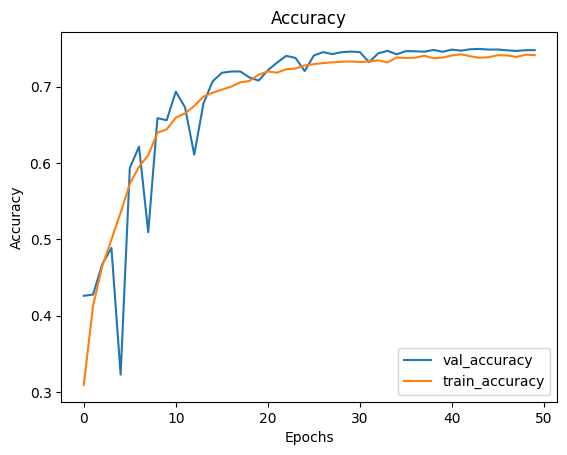

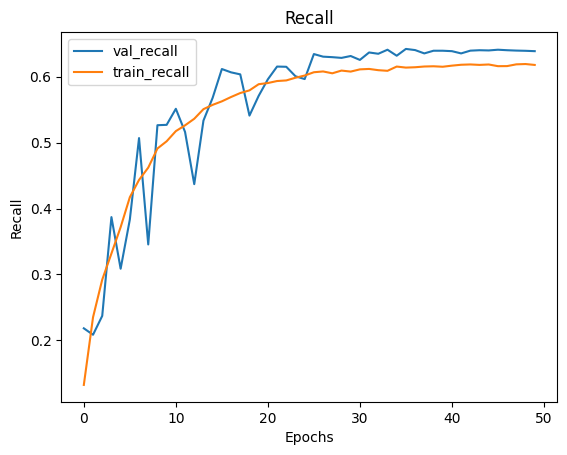

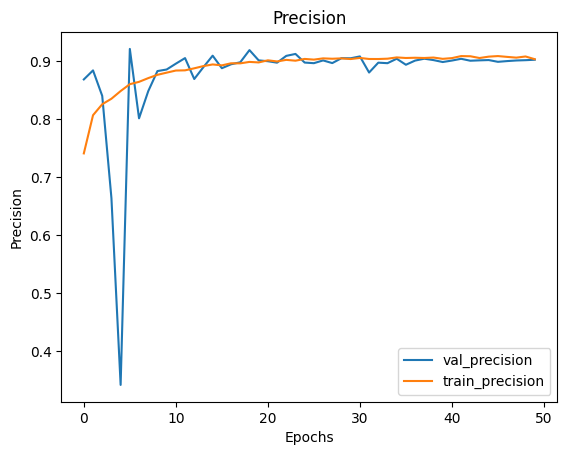

In [ ]:
visualize_training_results(initial_results)

##Model 2 training

In [ ]:
tf.random.set_seed(RANDOM_SEED)

model2 = tf.keras.Sequential([
    
    # First conv block
    tf.keras.layers.Conv2D(16, (3, 3), activation=None, 
                           input_shape=(SPEC_SHAPE[0], SPEC_SHAPE[1], 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Second conv block
    tf.keras.layers.Conv2D(32, (3, 3), activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Third conv block
    tf.keras.layers.Conv2D(64, (3, 3), activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)), 
    
    # Fourth conv block
    tf.keras.layers.Conv2D(128, (3, 3), activation=None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.ReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    # Global pooling instead of flatten()
    tf.keras.layers.GlobalAveragePooling2D(), 
    
    # Dense block
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),  
    tf.keras.layers.Dense(256, activation='relu'),   
    tf.keras.layers.Dropout(0.5),
    
    # Classification layer
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])


In [ ]:
model2.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 46, 126, 16)       160       
                                                                 
 batch_normalization_21 (Bat  (None, 46, 126, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_21 (ReLU)             (None, 46, 126, 16)       0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 23, 63, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 21, 61, 32)        4640      
                                                                 
 batch_normalization_22 (Bat  (None, 21, 61, 32)      

In [ ]:
learning_rate = 1e-3
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01),
              metrics=['accuracy', tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

In [ ]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                  patience=2, 
                                                  verbose=1, 
                                                  factor=0.5),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                              verbose=1,
                                              patience=20),
             tf.keras.callbacks.ModelCheckpoint(filepath='best_model2.h5', 
                                                monitor='val_loss',
                                                verbose=0,
                                                save_best_only=True)]

In [ ]:
EPOCHS = 50
BATCH_SIZE = 32
initial_results = model2.fit(train_specs, 
          train_labels,
          batch_size=BATCH_SIZE, 
          validation_data=(test_specs, test_labels),
          callbacks=callbacks,
          epochs=EPOCHS)

Epoch 1/50
1140/1140 [==============================] - 10s 9ms/step - loss: 1.4641 - accuracy: 0.5955 - recall_4: 0.4407 - precision_4: 0.8460 - val_loss: 1.6503 - val_accuracy: 0.5625 - val_recall_4: 0.4809 - val_precision_4: 0.7097 - lr: 0.0010
Epoch 2/50
1140/1140 [==============================] - 9s 8ms/step - loss: 1.2468 - accuracy: 0.6590 - recall_4: 0.5279 - precision_4: 0.8645 - val_loss: 1.2446 - val_accuracy: 0.6534 - val_recall_4: 0.5489 - val_precision_4: 0.8483 - lr: 0.0010
Epoch 3/50
1140/1140 [==============================] - 9s 8ms/step - loss: 1.1127 - accuracy: 0.7011 - recall_4: 0.5804 - precision_4: 0.8782 - val_loss: 1.3323 - val_accuracy: 0.6287 - val_recall_4: 0.5148 - val_precision_4: 0.8392 - lr: 0.0010
Epoch 4/50
1140/1140 [==============================] - 10s 9ms/step - loss: 1.0164 - accuracy: 0.7306 - recall_4: 0.6230 - precision_4: 0.8899 - val_loss: 1.0547 - val_accuracy: 0.7141 - val_recall_4: 0.6034 - val_precision_4: 0.8814 - lr: 0.0010
Epoch 5/50

# TESTING THE MODEL


## Creating test spectrograms

In [ ]:
#Extracting test spectrograms
inputdir = "/content/birdclef_data/train_audio"
outputdir = "/content/birdclef_data/test_spectrogram"
mel_test = []
with tqdm(total=len(test_set)) as pbar:
  for idx, row in test_set.iterrows():
    pbar.update(1)
    audiopath = os.path.join(inputdir, row.filename)
    mel_test += get_melspectrogram(audiopath, row.primary_label, outputdir)
TEST_SPECS = shuffle(mel_test, random_state=RANDOM_SEED)
print('SUCCESSFULLY EXTRACTED {} SPECTROGRAMS FOR TEST SET'.format(len(TEST_SPECS)))

100%|██████████| 500/500 [01:50<00:00,  4.54it/s]

SUCCESSFULLY EXTRACTED 3370 SPECTROGRAMS FOR TEST SET


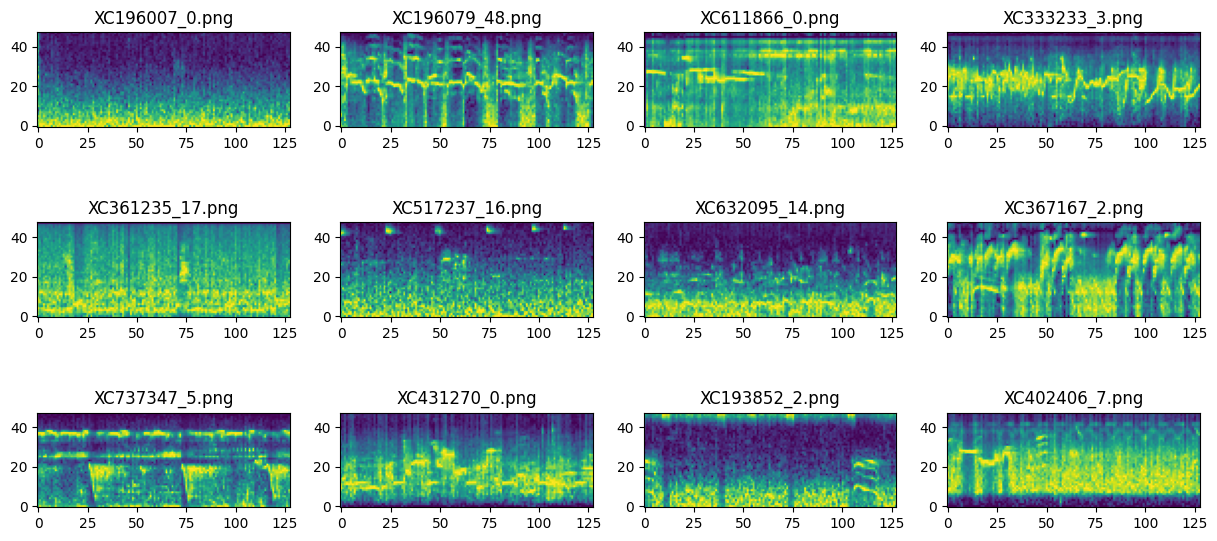

In [ ]:
#Visualizing test spectrograms
plt.figure(figsize=(15, 7))
for i in range(12):
    spec = Image.open(TEST_SPECS[i])
    plt.subplot(3, 4, i + 1)
    plt.title(TEST_SPECS[i].split(os.sep)[-1])
    plt.imshow(spec, origin='lower')

In [ ]:

X_test, y_test = reshapeSpectograms(TEST_SPECS, test_speciesname)
print(X_test.shape, y_test.shape)


100%|██████████| 3370/3370 [00:20<00:00, 162.26it/s]

(3370, 48, 128, 1) (3370, 164)


In [ ]:
true_label =[]
for name in y_test:
  true_label.append(test_speciesname[np.argmax(name)])


## Testing model 1

In [ ]:
#predict
p = model.predict(X_test)


106/106 [==============================] - 0s 2ms/step


In [ ]:
idx =[]
species_name =[]
for score in p:
  #find the index where the probability was high
  idx = score.argmax()
  if score[idx] > 0.25:
    species_name.append(labels[idx])
  else:
    species_name.append('nocall')




In [ ]:
correct_predictions = 0
for i in range(len(species_name)):
  if species_name[i] == true_label[i]:
    correct_predictions +=1
test_accuracy = correct_predictions/len(true_label)
print(f'The test accuracy using model 1 is {test_accuracy}')

The test accuracy using model 1 is 0.22492581602373887


## Testing model 2

In [ ]:
#predict
p2 = model2.predict(X_test)
idx =[]
species_name2 =[]
for score in p2:
  #find the index where the probability was high
  idx = score.argmax()
  if score[idx] > 0.25:
    species_name2.append(labels[idx])
  else:
    species_name2.append('nocall')

106/106 [==============================] - 0s 3ms/step


In [ ]:
correct_predictions = 0
for i in range(len(species_name2)):
  if species_name2[i] == true_label[i]:
    correct_predictions +=1
test_accuracy = correct_predictions/len(true_label)
print(f'The test accuracy using model 1 is {test_accuracy}')

The test accuracy using model 1 is 0.2459940652818991
